# CelebA Attribute Recognition Dataset Preparation and EDA

The dataset is structued as follows:
``` text
CelebA:
|---img_align_celeba
|----|-------000001.jpg
|----|-------000002.jpg
|----|-------...
|---list_attr_celeba.csv
|---list_bbox_celeba.csv
|---list_eval_partition.csv
|---list_landmarks_align_celeba.csv

It will be transformed into an images folder and a labels.csv file.

In [1]:
import numpy as np, os, shutil, PIL.Image as Image, matplotlib.pyplot as plt, pandas as pd
os.chdir('..')

In [2]:
import cv2
import numpy as np
import math

def align_face_rotation_bbox(img, landmarks, bbox, target_size=(112, 112), padding_factor=0.1):
    """
    Aligns face by rotating to make eyes horizontal and cropping the bounding box.
    
    Args:
        img: Original image (H, W, C)
        landmarks: 5x2 array (Eye_L, Eye_R, Nose, Mouth_L, Mouth_R)
        bbox: [x1, y1, x2, y2]
        target_size: tuple (112, 112)
        padding_factor: Float, expands the bbox slightly (e.g., 0.1 = 10% larger)
    """
    
    # 1. Calculate the Angle between Eyes
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    
    # Delta x and Delta y
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    
    # Calculate angle in degrees
    angle = np.degrees(np.arctan2(dy, dx))
    
    # 2. Get Rotation Matrix
    # We rotate around the center of the face (estimated by landmark center or image center)
    # Using the nose (index 2) or the midpoint of eyes as the pivot is safer than image center
    center_x = float((left_eye[0] + right_eye[0]) / 2)
    center_y = float((left_eye[1] + right_eye[1]) / 2)
    eye_center = (center_x, center_y)
    M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    
    # 3. Rotate the Image
    h, w = img.shape[:2]
    rotated_img = cv2.warpAffine(img, M, (w, h))
    
    # 4. Rotate the Bounding Box Points to find the new crop area
    # We must transform the bbox corners to the new rotated coordinate system
    # BBox format: x1, y1, x2, y2
    bbox_points = np.array([
        [bbox[0], bbox[1]], # Top-left
        [bbox[2], bbox[1]], # Top-right
        [bbox[2], bbox[3]], # Bottom-right
        [bbox[0], bbox[3]]  # Bottom-left
    ])
    
    # Add a column of ones for matrix multiplication
    ones = np.ones(shape=(len(bbox_points), 1))
    points_ones = np.hstack([bbox_points, ones])
    
    # Apply rotation matrix to the bbox corners
    rotated_points = M.dot(points_ones.T).T
    
    # 5. Determine New Bounding Box (Axis Aligned) around the rotated rectangle
    rx_min = np.min(rotated_points[:, 0])
    rx_max = np.max(rotated_points[:, 0])
    ry_min = np.min(rotated_points[:, 1])
    ry_max = np.max(rotated_points[:, 1])
    
    # 6. Make the Crop Square (Crucial for 112x112 without distortion)
    rw = rx_max - rx_min
    rh = ry_max - ry_min
    max_side = max(rw, rh)
    
    # Calculate center of the new bbox
    cx = (rx_min + rx_max) / 2
    cy = (ry_min + ry_max) / 2
    
    # Apply padding
    max_side = max_side * (1 + padding_factor)
    
    # Calculate final square coordinates
    crop_x1 = int(cx - max_side / 2)
    crop_y1 = int(cy - max_side / 2)
    crop_x2 = int(cx + max_side / 2)
    crop_y2 = int(cy + max_side / 2)
    
    # 7. Crop and Pad (Handle boundaries)
    # If the crop falls outside the image, we pad with black (or mean color)
    pad_top = max(0, -crop_y1)
    pad_bottom = max(0, crop_y2 - h)
    pad_left = max(0, -crop_x1)
    pad_right = max(0, crop_x2 - w)
    
    # If padding is needed, re-pad the rotated image
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        rotated_img = cv2.copyMakeBorder(rotated_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0,0,0])
        # Adjust coords because image got bigger
        crop_y1 += pad_top
        crop_y2 += pad_top
        crop_x1 += pad_left
        crop_x2 += pad_left

    face_crop = rotated_img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # 8. Final Resize
    return cv2.resize(face_crop, target_size)

In [3]:
dataset_dir = os.path.join('data', 'datasets', 'attribute recognition', 'CelebA')
os.path.exists(dataset_dir)

True

In [4]:
output_images_dir = os.path.join(dataset_dir, 'Images')
os.makedirs(output_images_dir, exist_ok = True)

In [5]:
old_images_dir = os.path.join(dataset_dir, 'celeba full', 'img_celeba')
os.path.exists(old_images_dir)

True

In [6]:
attributes_file = pd.read_csv(os.path.join(dataset_dir, 'list_attr_celeba.csv'))

In [7]:
attributes_file.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


extract landmarks for alignment

In [8]:
landmarks_file = os.path.join(dataset_dir, 'celeba full', 'list_landmarks_celeba.txt')
os.path.exists(landmarks_file)

lines = []
with open(landmarks_file, 'r') as file:
    lines = file.readlines()

landmarks = []
filenames = []
for line in lines[2:]: # skip the first two since they don't contain information
    # cleanup
    line = line.replace('   ', ' ')
    line = line.replace('  ', ' ')
    image_name, left_eye_x, left_eye_y, right_eye_x, right_eye_y, nose_x, nose_y, left_mouth_x, left_mouth_y, right_mouth_x, right_mouth_y = line.split(sep = ' ')
    right_mouth_y.replace('\n','')

    landmark = np.array([
        [int(left_eye_x), int(left_eye_y)],
        [int(right_eye_x), int(right_eye_y)],
        [int(nose_x), int(nose_y)],
        [int(left_mouth_x), int(left_mouth_y)],
        [int(right_mouth_x), int(right_mouth_y)]
    ])

    landmarks.append(landmark)
    filenames.append(image_name)

In [9]:
bbox_file = pd.read_csv(os.path.join(dataset_dir, 'list_bbox_celeba.csv'))

In [10]:
evaluation_partition_file = pd.read_csv(os.path.join(dataset_dir, 'list_eval_partition.csv'))

In [11]:
evaluation_partition_file.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [12]:
evaluation_partition_file['partition'] = evaluation_partition_file['partition'].replace(0, 'train')
evaluation_partition_file['partition'] = evaluation_partition_file['partition'].replace(1, 'validation')
evaluation_partition_file['partition'] = evaluation_partition_file['partition'].replace(2, 'test')
evaluation_partition_file.head()

,image_id,partition
0,000001.jpg,train
1,000002.jpg,train
2,000003.jpg,train
3,000004.jpg,train
4,000005.jpg,train


In [13]:
attributes_file['split'] = evaluation_partition_file['partition'].replace()
attributes_file.head()

/tmp/ipykernel_227953/2513961335.py:1: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  attributes_file['split'] = evaluation_partition_file['partition'].replace()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,train
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,train
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,train
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,train
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,train


## Preprocessing

In [14]:
bbox_file.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [15]:
bbox_file.iloc[101282]

image_id    101283.jpg
x_1                320
y_1                828
width                0
height               0
Name: 101282, dtype: object

In [16]:
rows_to_drop = []
for i in range(len(filenames)):
    image_id = filenames[i]
    landmark = landmarks[i]
    attribute = attributes_file.iloc[i][1:-1]
    split = attributes_file.iloc[i][-1]
    
    bbox_x1 = bbox_file.iloc[i].x_1
    bbox_y1 = bbox_file.iloc[i].y_1
    bbox_width = bbox_file.iloc[i].width
    bbox_height = bbox_file.iloc[i].height

    x1 = int(bbox_x1)
    y1 = int(bbox_y1)
    x2 = int(bbox_x1 + bbox_width)
    y2 = int(bbox_y1 + bbox_height)
    image = cv2.imread(os.path.join(old_images_dir, image_id))
    
    try:
        image = align_face_rotation_bbox(image, landmarks = landmark, bbox = [x1, y1, x2, y2], target_size = (112, 112), padding_factor = 0.3)
    except:
        rows_to_drop.append(i)
        continue # drop images that cause errors. There is only one such image that has a height and width of 0
    
    cv2.imwrite(
        os.path.join(output_images_dir, image_id),
        image
    )




/tmp/ipykernel_227953/2381553948.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  split = attributes_file.iloc[i][-1]


In [17]:
attributes_file = attributes_file.rename(columns = {'image_id' : 'filename'})
attributes_file.drop(rows_to_drop, inplace = True)
attributes_file.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,train
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,train
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,train
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,train
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,train


In [18]:
attribute_groups = {
            'mouth' : ['5_o_Clock_Shadow', 'Big_Lips', 'Mouth_Slightly_Open', 'Mustache', 'Wearing_Lipstick', 'No_Beard'],
            'ear' : ['Wearing_Earrings'],
            'lower_face': ['Double_Chin', 'Goatee', 'Wearing_Necklace', 'Wearing_Necktie'],
            'cheeks' : ['High_Cheekbones', 'Rosy_Cheeks', 'Sideburns'],
            'nose' : ['Big_Nose', 'Pointy_Nose'],
            'eyes' : ['Arched_Eyebrows', 'Bags_Under_Eyes', 'Bushy_Eyebrows', 'Narrow_Eyes', 'Eyeglasses'],
            'hair' : ['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat'],
            'object' : ['Attractive', 'Blurry', 'Chubby', 'Heavy_Makeup', 'Male', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Young']
        }

In [19]:
count = 0
for key, value in attribute_groups.items():
    print(len(value))
    count += len(value)

6
1
4
3
2
5
10
9


In [20]:
columns = attributes_file.columns

In [21]:
indices = []
for keys, values in attribute_groups.items():
    for value in values:
        indices.append(int(np.nonzero(columns == value)[0]))

/tmp/ipykernel_227953/2891627716.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices.append(int(np.nonzero(columns == value)[0]))


In [22]:
indices.insert(0, 0)
indices.insert(len(indices), 41)

In [23]:
attributes_file = attributes_file.iloc[:, indices]

In [24]:
attributes_file.to_csv(
    os.path.join(dataset_dir, 'labels.csv'),
    index = False,
)

In [25]:
len(attributes_file.columns)

42

## EDA

In [26]:
labels_file = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'))

In [27]:
for column in labels_file.columns:
    print(column)

filename
5_o_Clock_Shadow
Big_Lips
Mouth_Slightly_Open
Mustache
Wearing_Lipstick
No_Beard
Wearing_Earrings
Double_Chin
Goatee
Wearing_Necklace
Wearing_Necktie
High_Cheekbones
Rosy_Cheeks
Sideburns
Big_Nose
Pointy_Nose
Arched_Eyebrows
Bags_Under_Eyes
Bushy_Eyebrows
Narrow_Eyes
Eyeglasses
Bald
Bangs
Black_Hair
Blond_Hair
Brown_Hair
Gray_Hair
Receding_Hairline
Straight_Hair
Wavy_Hair
Wearing_Hat
Attractive
Blurry
Chubby
Heavy_Makeup
Male
Oval_Face
Pale_Skin
Smiling
Young
split


In [28]:
(labels_file['split'] == 'train').sum(), (labels_file['split'] == 'test').sum(), (labels_file['split'] == 'validation').sum()

(np.int64(162769), np.int64(19962), np.int64(19867))

In [29]:
labels_file.head()

,filename,5_o_Clock_Shadow,Big_Lips,Mouth_Slightly_Open,Mustache,Wearing_Lipstick,No_Beard,Wearing_Earrings,Double_Chin,Goatee,...,Attractive,Blurry,Chubby,Heavy_Makeup,Male,Oval_Face,Pale_Skin,Smiling,Young,split
0,000001.jpg,-1,-1,1,-1,1,1,1,-1,-1,...,1,-1,-1,1,-1,-1,-1,1,1,train
1,000002.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,1,train
2,000003.jpg,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,-1,1,train
3,000004.jpg,-1,-1,-1,-1,1,1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,train
4,000005.jpg,-1,1,-1,-1,1,1,-1,-1,-1,...,1,-1,-1,1,-1,-1,-1,-1,1,train


In [30]:
counts = {}
columns = list(labels_file.columns)[1:-1] # only keep the attributes
for column in columns:
    values = labels_file[column]
    values.replace(-1, 0, inplace = True)
    counts[column] = sum(values)

In [31]:
sorted_index = np.argsort(list(counts.values()))
x = [key for key in counts.keys()]
y = [value for value in counts.values()]
x = [x[i] for i in sorted_index]
y = [y[i] for i in sorted_index]


In [32]:
figures_path = os.path.join('data', 'figures', 'Attribute Recognition', 'CelebA')
os.makedirs(figures_path, exist_ok = True)

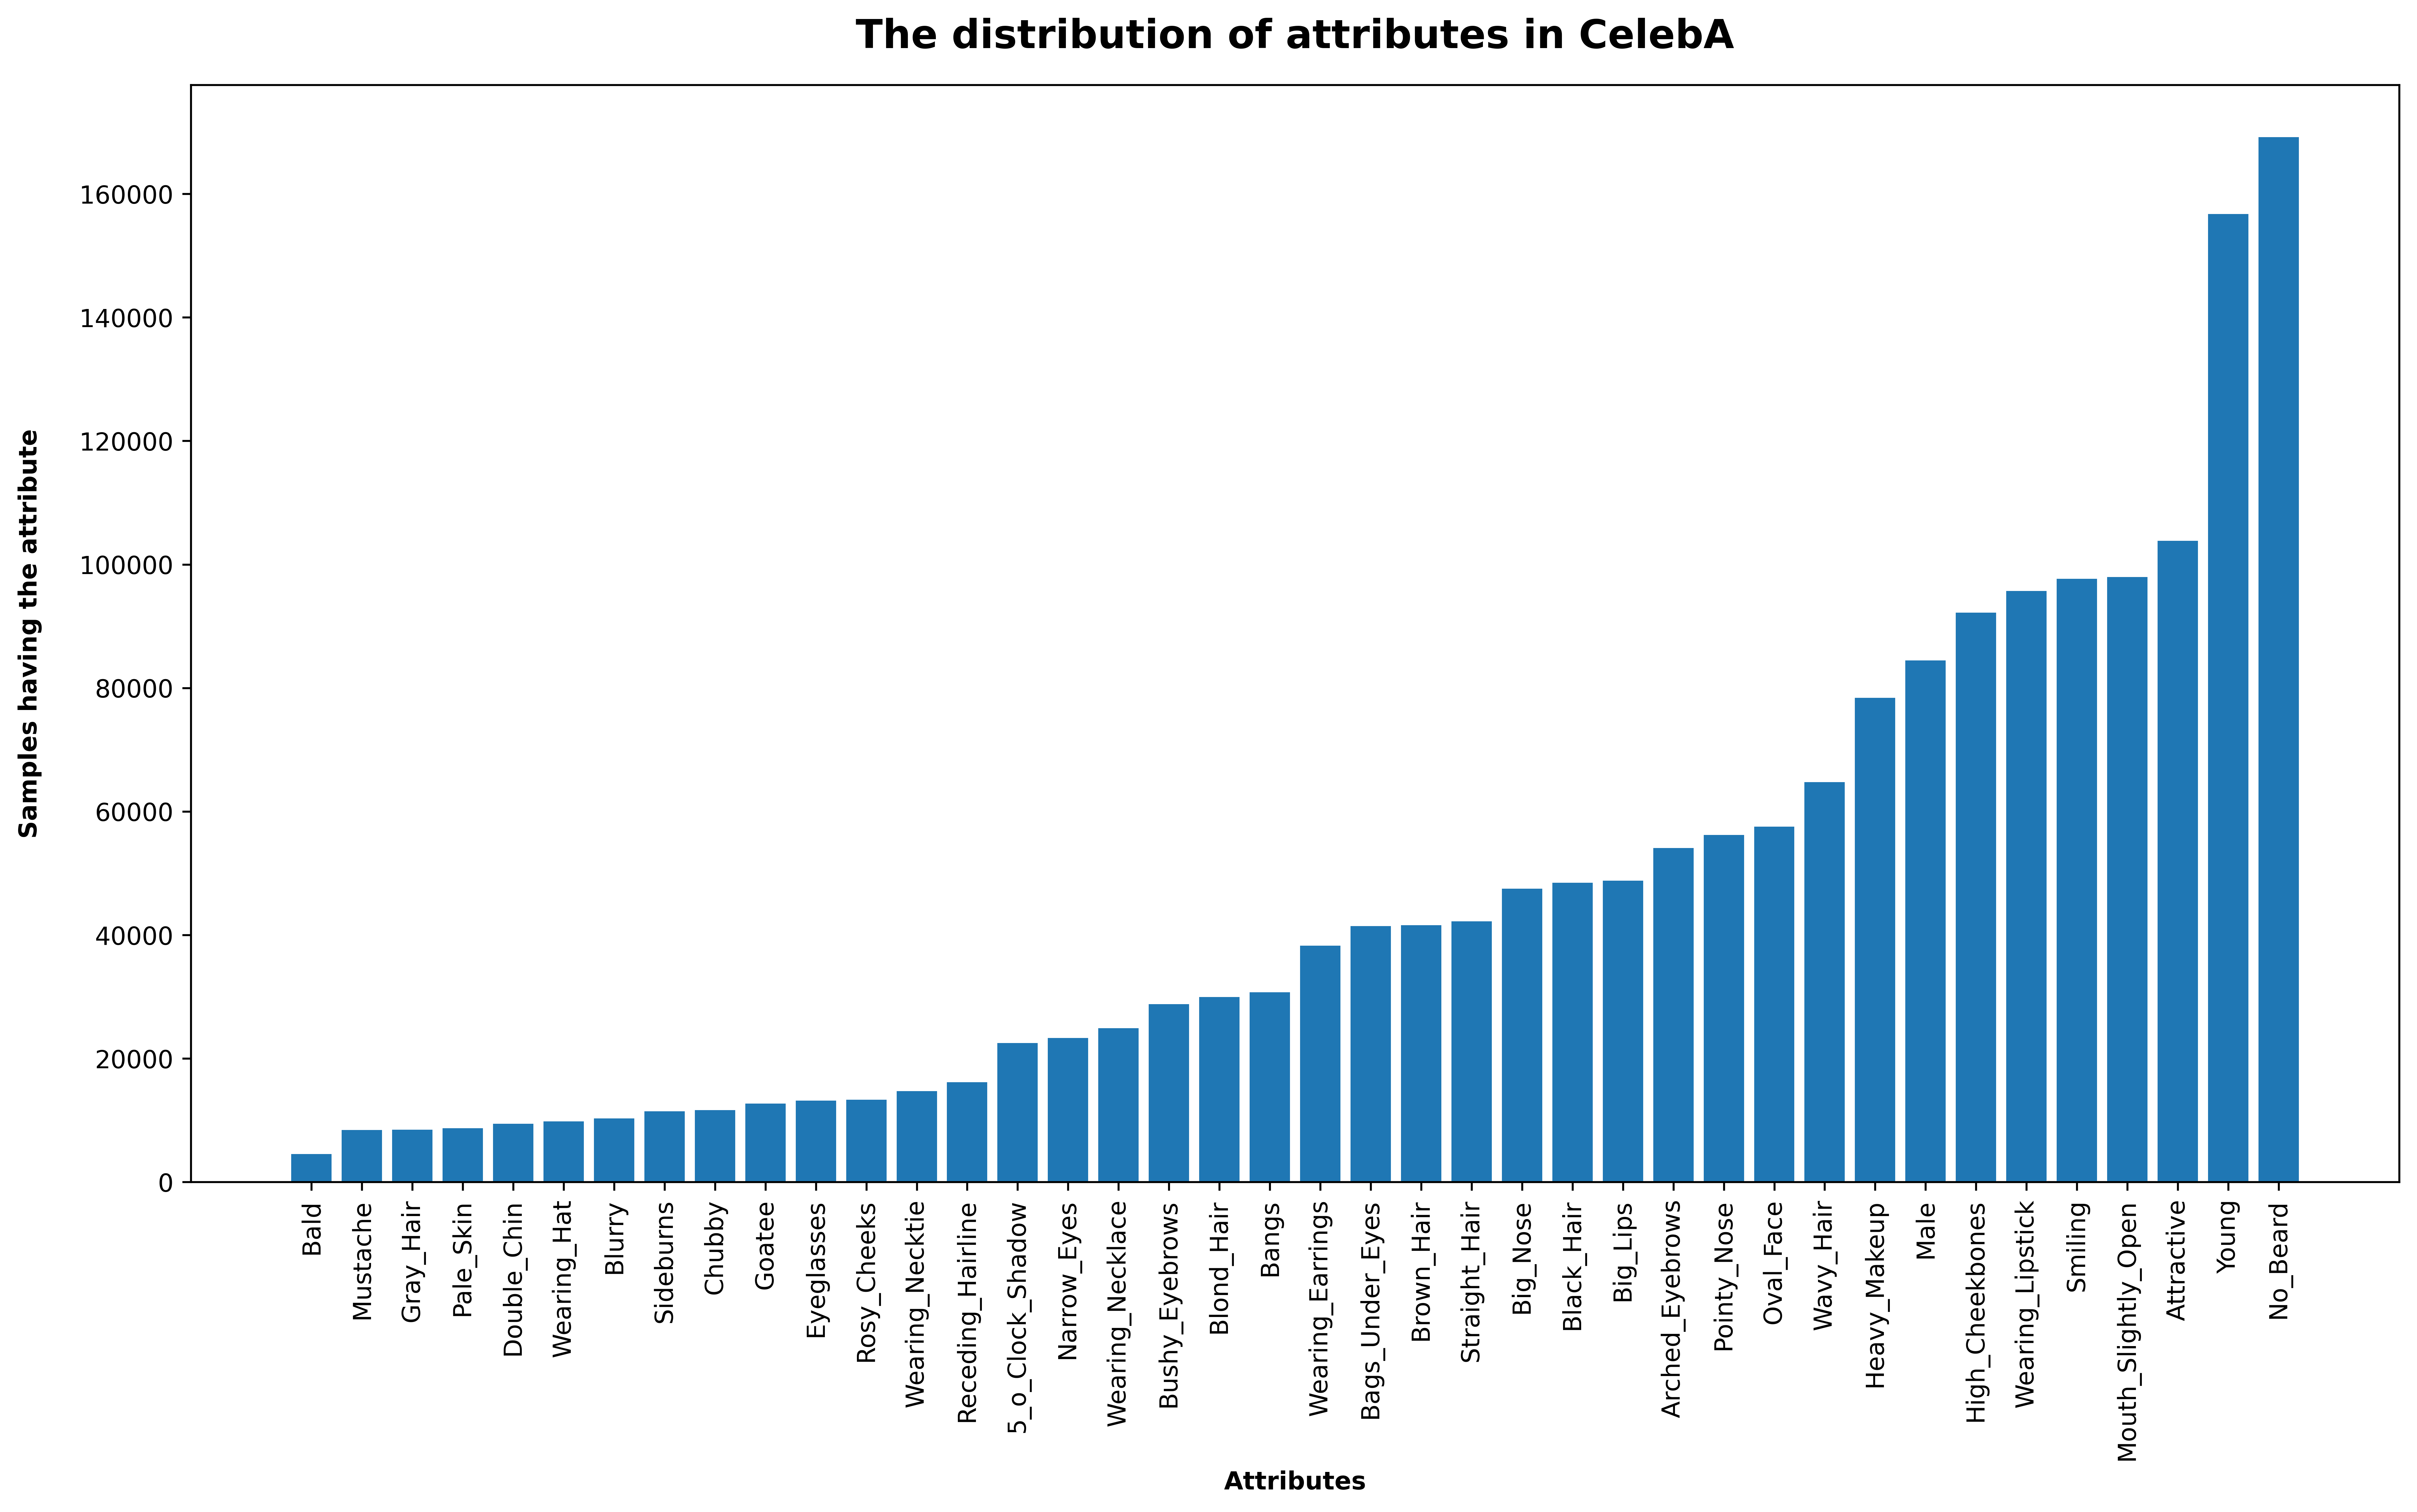

In [33]:
plt.figure(figsize = (16, 8), dpi = 600)
plt.title('The distribution of attributes in CelebA', fontweight = 'bold', fontsize = 16, pad = 15)
plt.bar(x, y)
plt.xticks(rotation = 90)
plt.xlabel('Attributes', fontweight = 'bold')
plt.ylabel('Samples having the attribute', labelpad = 15, fontweight = 'bold')
plt.savefig(
    os.path.join(figures_path, 'The distribution of attributes in CelebA'),
    bbox_inches = 'tight'
)
plt.show()

In [34]:
attributes_list = np.array(list(labels_file.columns)[1:-1])

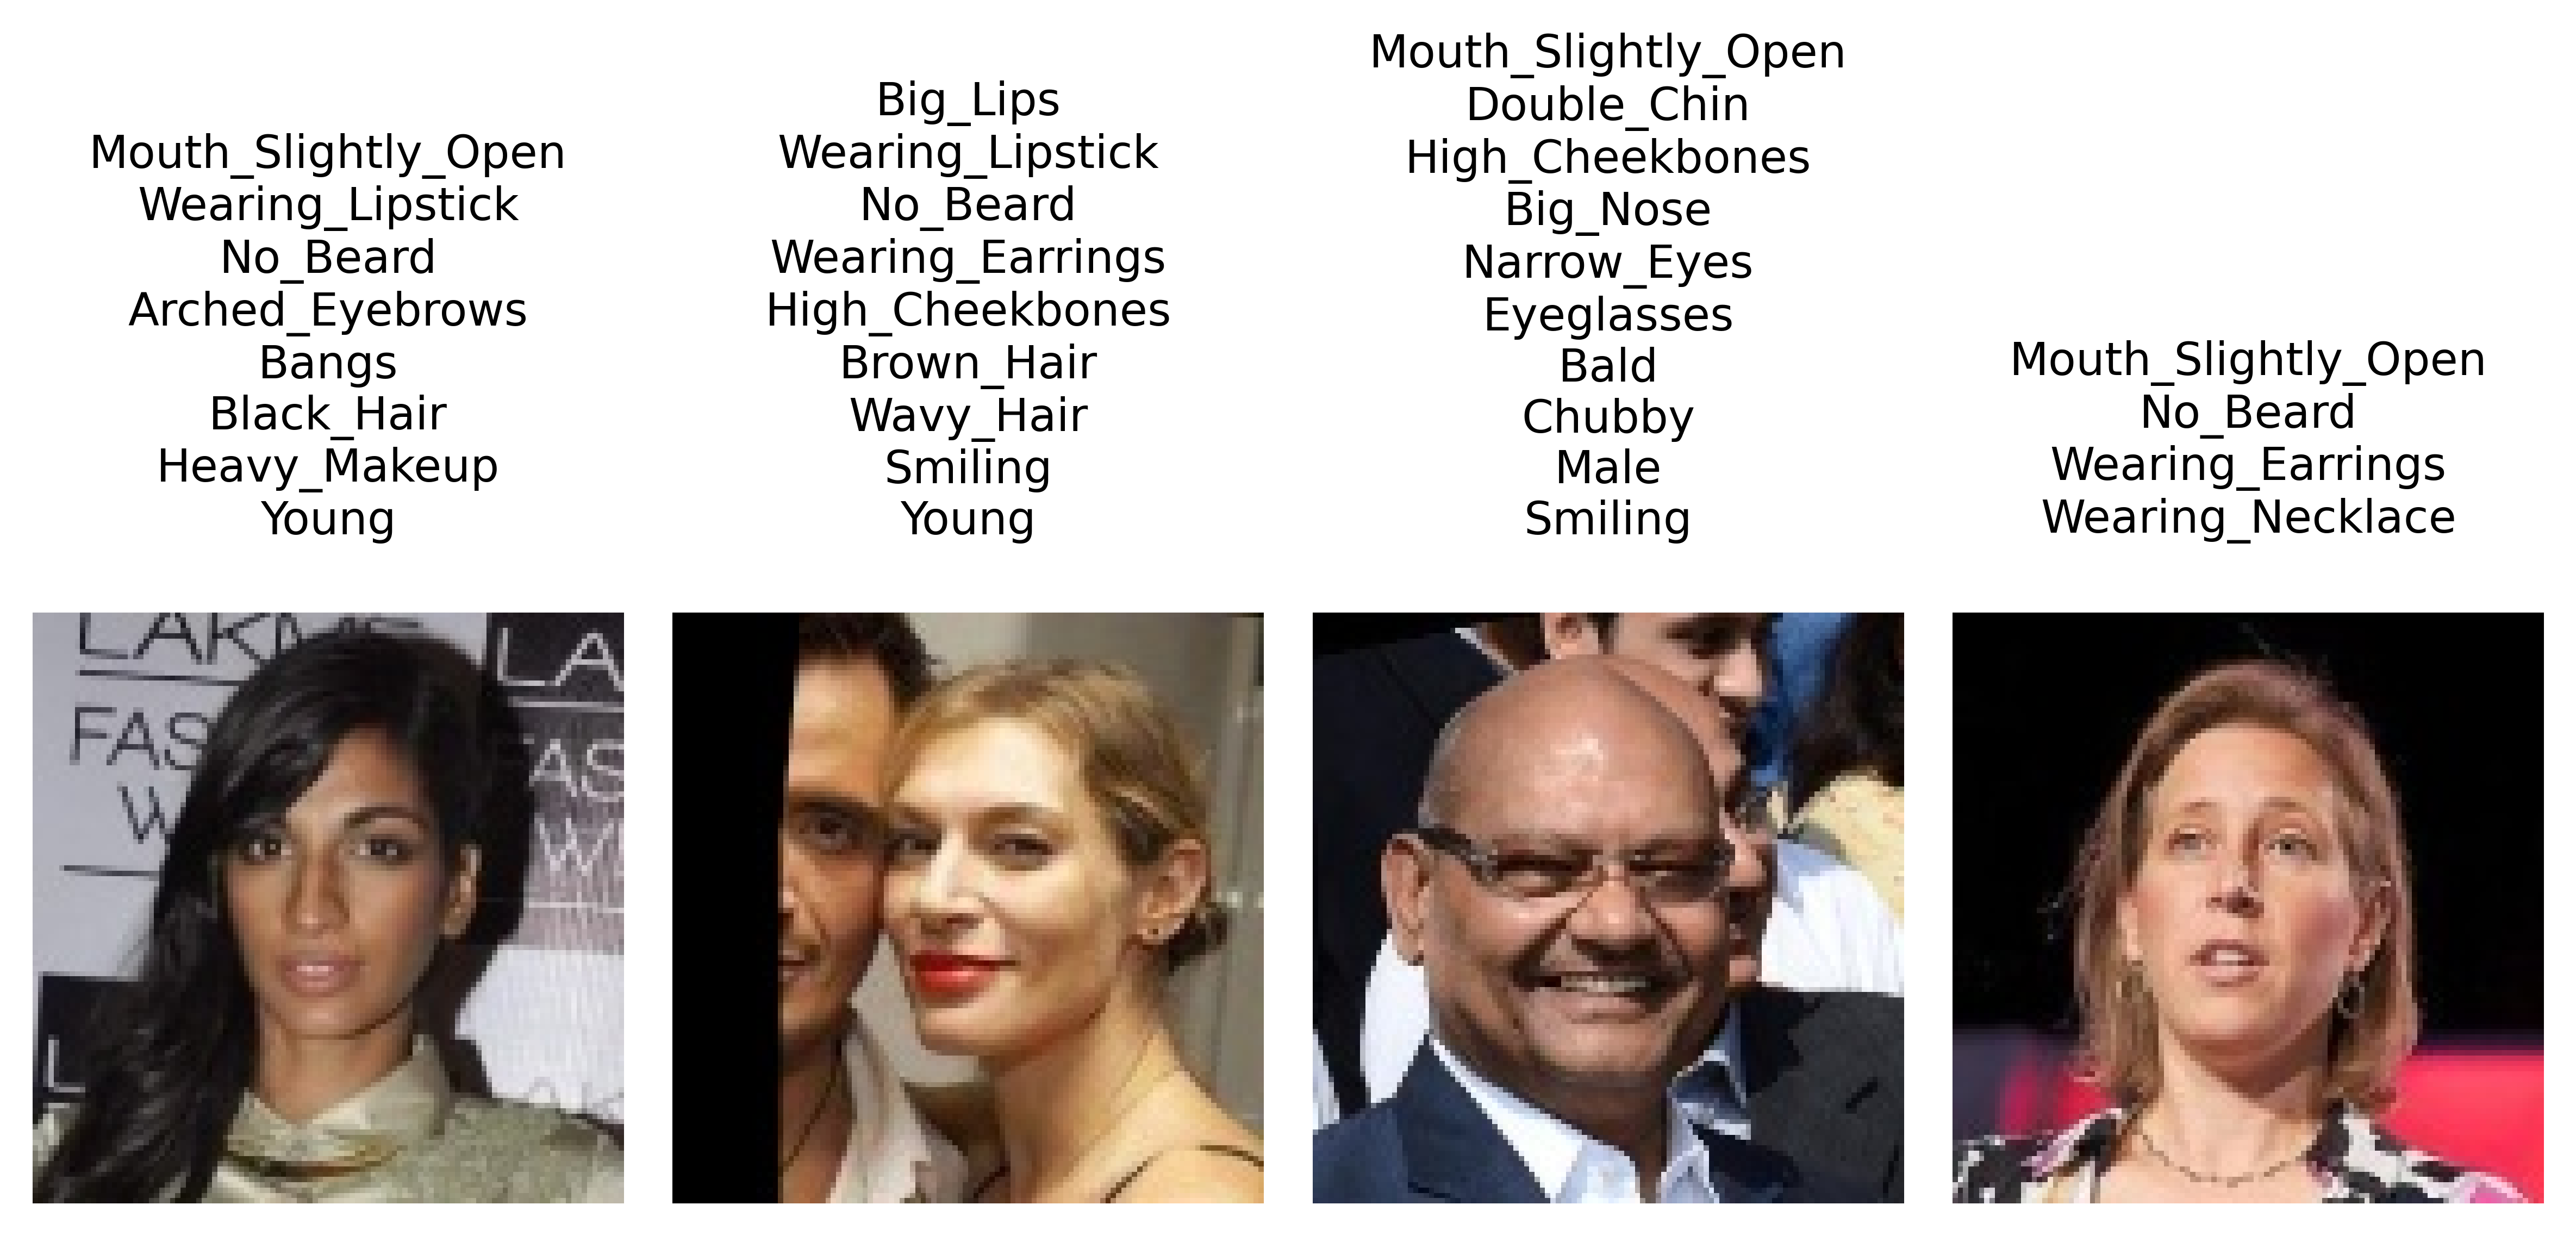

In [35]:
plt.figure(figsize = (8, 8), dpi = 600)
for i in range(4):
    image_index = np.random.randint(low = 0, high = len(labels_file))
    image_name = labels_file['filename'].iloc[image_index]
    attributes_indices = np.array(list(labels_file.iloc[image_index])[1:-1])
    attributes = attributes_list[attributes_indices == 1]
    image = Image.open(os.path.join(output_images_dir, image_name))

    plt.subplot(1, 4, i+1)
    title_string = ''
    for attribute in attributes:
        title_string += attribute + '\n'
    plt.title(title_string, fontsize = 10)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
plt.savefig(
    os.path.join(figures_path, 'Sample images from CelebA'),
    bbox_inches = 'tight'
)
plt.show()